In [1]:
import matplotlib.pyplot as plt
import os,glob,imp,copy
import numpy as np
import seaborn as sns
import pyslha, copy, pickle
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels,ylog=False,xlog=False):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    
    #Use log scale:
    if ylog:
        y = np.log10(y)
    if xlog:
        x = np.log10(x)
    
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    #scale back:
    if ylog or xlog:
        for key,ptsList in levelPts.items():
            newList = []
            for pts in ptsList:
                xpts = pts[:,0]
                ypts = pts[:,1]
                if xlog:
                    xpts = 10**xpts
                if ylog:
                    ypts = 10**ypts
                newList.append(np.column_stack((xpts,ypts)))
            levelPts[key] = newList
        
    
    return levelPts

In [3]:
exec(open("./TDTM1F_2EqMassAx_EqWidthAy_EqMassBx.py").read())
dataC1C1 = copy.deepcopy(validationData)
exec(open("./TDTM2F_EqMassAx_EqWidthAy_EqMassBx__EqmassAx.py").read())
dataC1N1 = copy.deepcopy(validationData)

In [4]:
slhaFiles = [pt['slhafile'] for pt in dataC1C1]
slhaFilesB = [pt['slhafile'] for pt in dataC1N1]
missing = set(slhaFiles).difference(set(slhaFilesB))
for f in missing:
    dataC1N1.append({'slhafile': f, 'error': 'no results', 'axes': None})

In [5]:
dataC1C1 = sorted(dataC1C1, key = lambda pt: pt['slhafile'])
dataC1N1 = sorted(dataC1N1, key = lambda pt: pt['slhafile'])

In [6]:
dataComb = copy.deepcopy(dataC1N1)
dataCombFix = copy.deepcopy(dataC1N1)
for i,pt in enumerate(dataComb):
    ptFix = dataCombFix[i]
    C1C1pt = dataC1C1[i]
    if not 'signal' in C1C1pt:
        continue
    if not 'signal' in pt:
        pt['signal'] = C1C1pt['signal']
        ptFix['signal'] = 2*C1C1pt['signal']
    else:
        pt['signal'] += C1C1pt['signal']
        ptFix['signal'] += 2*C1C1pt['signal']
    dataComb[i] = pt
    dataCombFix[i] = ptFix


In [7]:
xpts = [pt['axes']['x'] for pt in dataComb if not 'error' in pt]
ypts = [pt['axes']['y'] for pt in dataComb if not 'error' in pt]
rpts = [pt['signal']/pt['UL'] for pt in dataComb if not 'error' in pt]
excCurve = getContour(xpts,ypts,rpts,levels=[0.83,1.0],ylog=True)

In [8]:
#Official curve
excCMS = np.genfromtxt('../orig/Wino_ExclusionObs.csv',delimiter=',',
                       names=True)


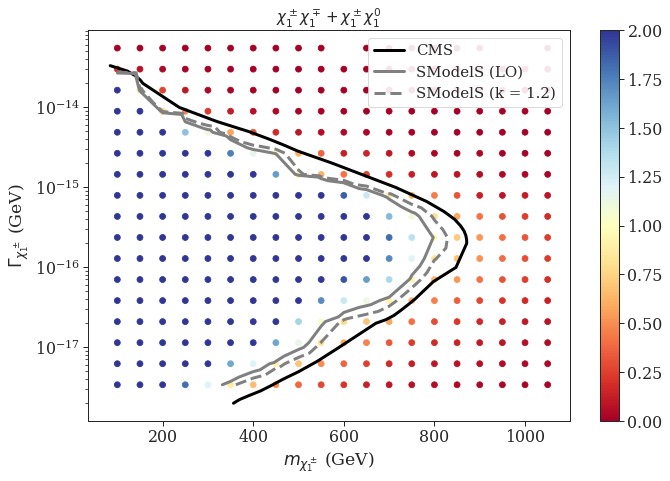

In [9]:
fig = plt.figure(figsize=(10,7))
plt.scatter(xpts,ypts,c=rpts,s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)

plt.plot(excCMS['Observed_95_CL_upper_limits_on_chargino_mass_pb'],excCMS['Chargino_width_GeV'],
         label='CMS',linewidth=3,linestyle='-',color='black')


plt.plot(excCurve[1.0][0][:,0],excCurve[1.0][0][:,1],
         label='SModelS (LO)',
         linewidth=3,linestyle='-',color='gray')
plt.plot(excCurve[0.83][0][:,0],excCurve[0.83][0][:,1],
         linewidth=3,linestyle='--',color='gray',label='SModelS (k = 1.2)')
# plt.plot(excCurve[1.2][0][:,0],excCurve[1.2][0][:,1],
#          linewidth=3,linestyle='--',color='gray')



plt.ylabel(r'$\Gamma_{\chi_1^\pm}$ (GeV)')
plt.xlabel(r'$m_{\chi_1^\pm}$ (GeV)')
plt.yscale('log')
plt.title(r'$\chi_1^\pm \chi_1^\mp + \chi_1^\pm \chi_1^0$',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=0.9,loc='upper right',fontsize=15)
plt.colorbar()
plt.savefig('combinedChannels.png')
plt.show()

In [12]:
xpts = [pt['axes']['x'] for pt in dataCombFix if not 'error' in pt]
ypts = [pt['axes']['y'] for pt in dataCombFix if not 'error' in pt]
rpts = [pt['signal']/pt['UL'] for pt in dataCombFix if not 'error' in pt]
excCurveFix = getContour(xpts,ypts,rpts,levels=[0.83,1.0],ylog=True)

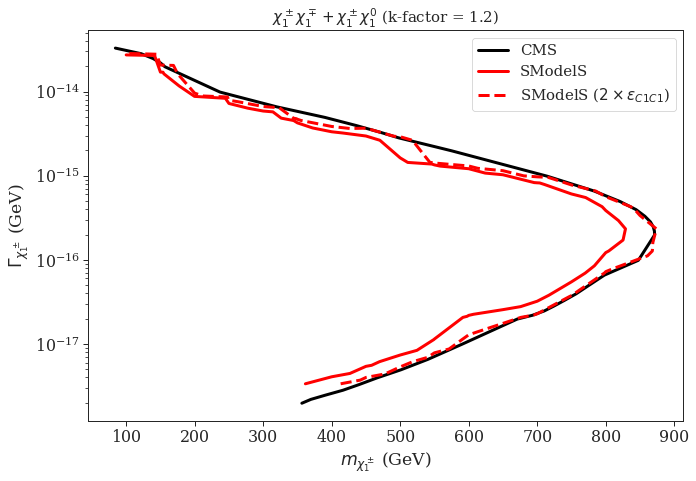

In [16]:
fig = plt.figure(figsize=(10,7))

plt.plot(excCMS['Observed_95_CL_upper_limits_on_chargino_mass_pb'],excCMS['Chargino_width_GeV'],
         label='CMS',linewidth=3,linestyle='-',color='black')


plt.plot(excCurve[0.83][0][:,0],excCurve[0.83][0][:,1],
         linewidth=3,linestyle='-',color='red',label='SModelS')

plt.plot(excCurveFix[0.83][0][:,0],excCurveFix[0.83][0][:,1],
         linewidth=3,linestyle='--',color='red',label=r'SModelS ($2\times \epsilon_{C1C1}$)')



plt.ylabel(r'$\Gamma_{\chi_1^\pm}$ (GeV)')
plt.xlabel(r'$m_{\chi_1^\pm}$ (GeV)')
plt.yscale('log')
plt.title(r'$\chi_1^\pm \chi_1^\mp + \chi_1^\pm \chi_1^0$ (k-factor = 1.2)',fontsize=15)
plt.tight_layout()
plt.legend(framealpha=0.9,loc='upper right',fontsize=15)
plt.savefig('combinedChannelsFix.png')
plt.show()